# EDA Sentiment Analysis

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('punkt')
from nltk import tokenize
from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

In [51]:
df = pd.read_csv('dataset.tsv', delimiter="\t", header=None)

df.columns = ["Sentiment", "Comment"]

df.head()

,Sentiment,Comment
0,neg,ab achanak khawaja saad rafique ko khiyaal aa...
1,neg,"adha drama to censor hi hojaye gaa , khaas to..."
2,neg,bekaar fuzool end !!!!! moti budhi laila jeet...
3,neg,choor kasuri choor jhootay ka moo kaala
4,neg,gali gali mein shor hai gaaanjaaaa shair chor...


Veamos cuántas categorías cuenta el dataset.

In [52]:
df['Sentiment'].unique()

array(['neg', ' ', 'pos'], dtype=object)

Vemos que hay una categoría negativa, otra positiva y otra vacía. Veamos cuantas observaciones hay para cada categoría.

In [53]:
df.iloc[:, 0].value_counts()

Sentiment
pos    5699
neg    5300
          1
Name: count, dtype: int64

Vemos que para la categoría vacía solo hay una observación por lo que vamos a eliminar esta fila. También contamos con 5699 observaciones para la categoría de sentimiento positivo y 5300 para el sentimiento negativo.

In [54]:
df = df[df['Sentiment'].str.strip() != ""]

Veamos gráficamente la distribución de las categorías.

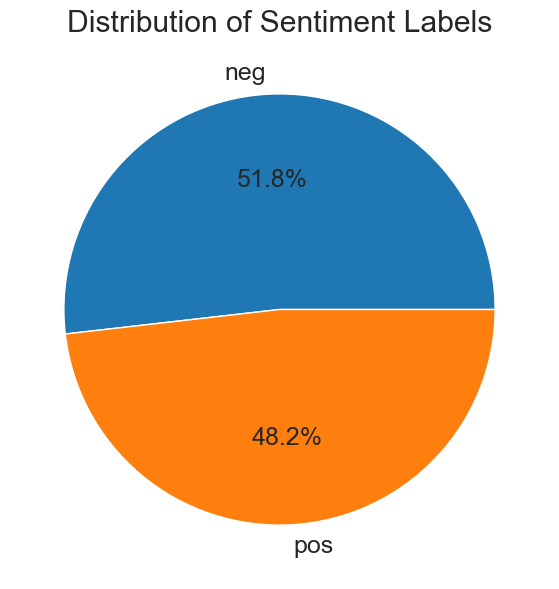

In [55]:
plt.pie(df['Sentiment'].value_counts(), 
        labels=df['Sentiment'].unique().tolist(), 
        autopct='%1.1f%%')
plt.title("Distribution of Sentiment Labels")
plt.show()

Vemos que el 51.8% corresponden a textos con sentimiento negativo y el 48.2% corresponden a textos con sentimiento positivo.
Ahora veamos la longitud de las palabras de los textos.

In [56]:
df['comment_length'] = df.iloc[:, 1].astype(str).apply(len)
df.head()

,Sentiment,Comment,comment_length
0,neg,ab achanak khawaja saad rafique ko khiyaal aa...,116
1,neg,"adha drama to censor hi hojaye gaa , khaas to...",471
2,neg,bekaar fuzool end !!!!! moti budhi laila jeet...,223
3,neg,choor kasuri choor jhootay ka moo kaala,40
4,neg,gali gali mein shor hai gaaanjaaaa shair chor...,51


In [57]:
df['comment_length'].describe()

count    10999.000000
mean       122.189745
std        144.727664
min          1.000000
25%         46.000000
50%         80.000000
75%        136.000000
max       2403.000000
Name: comment_length, dtype: float64

La longitud de los comentarios en este dataset varía ampliamente, con un promedio de 122 caracteres y una mediana de 80, lo que indica que la mayoría de los comentarios son cortos, aunque existen algunos comentarios mucho más largos que elevan el promedio. La longitud mínima es de 1 carácter, mientras que la máxima alcanza los 2,403 caracteres, reflejando desde reacciones rápidas hasta opiniones detalladas.

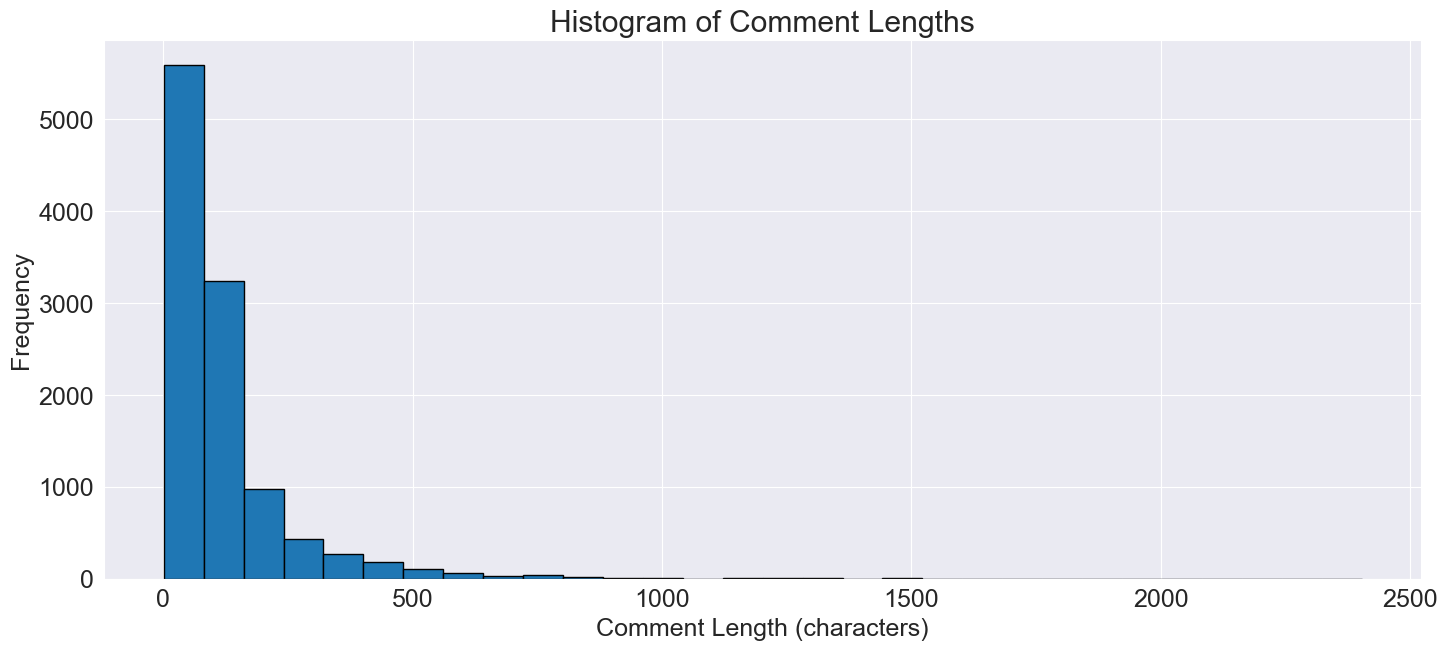

In [58]:
plt.hist(df['comment_length'], bins=30, edgecolor='black')
plt.xlabel("Comment Length (characters)")
plt.ylabel("Frequency")
plt.title("Histogram of Comment Lengths")
plt.show()

La distribución es altamente sesgada hacia la izquierda, lo que indica que una gran cantidad de comentarios tienen menos de 100 caracteres, con un pico notable en el rango más bajo de la longitud. A medida que la longitud de los comentarios aumenta, la frecuencia disminuye drásticamente, lo que sugiere que los comentarios largos son poco comunes. Hay unos pocos comentarios que alcanzan o superan los 500 caracteres, y muy pocos llegan hasta los 1,000 o más caracteres.

Ahora veamos la distribución de los comentarios según la cantidad de palabras que posee.

In [59]:
df['Word_count'] = df['Comment'].apply(lambda x: len(str(x).split()))
df.head()


,Sentiment,Comment,comment_length,Word_count
0,neg,ab achanak khawaja saad rafique ko khiyaal aa...,116,22
1,neg,"adha drama to censor hi hojaye gaa , khaas to...",471,93
2,neg,bekaar fuzool end !!!!! moti budhi laila jeet...,223,45
3,neg,choor kasuri choor jhootay ka moo kaala,40,7
4,neg,gali gali mein shor hai gaaanjaaaa shair chor...,51,9


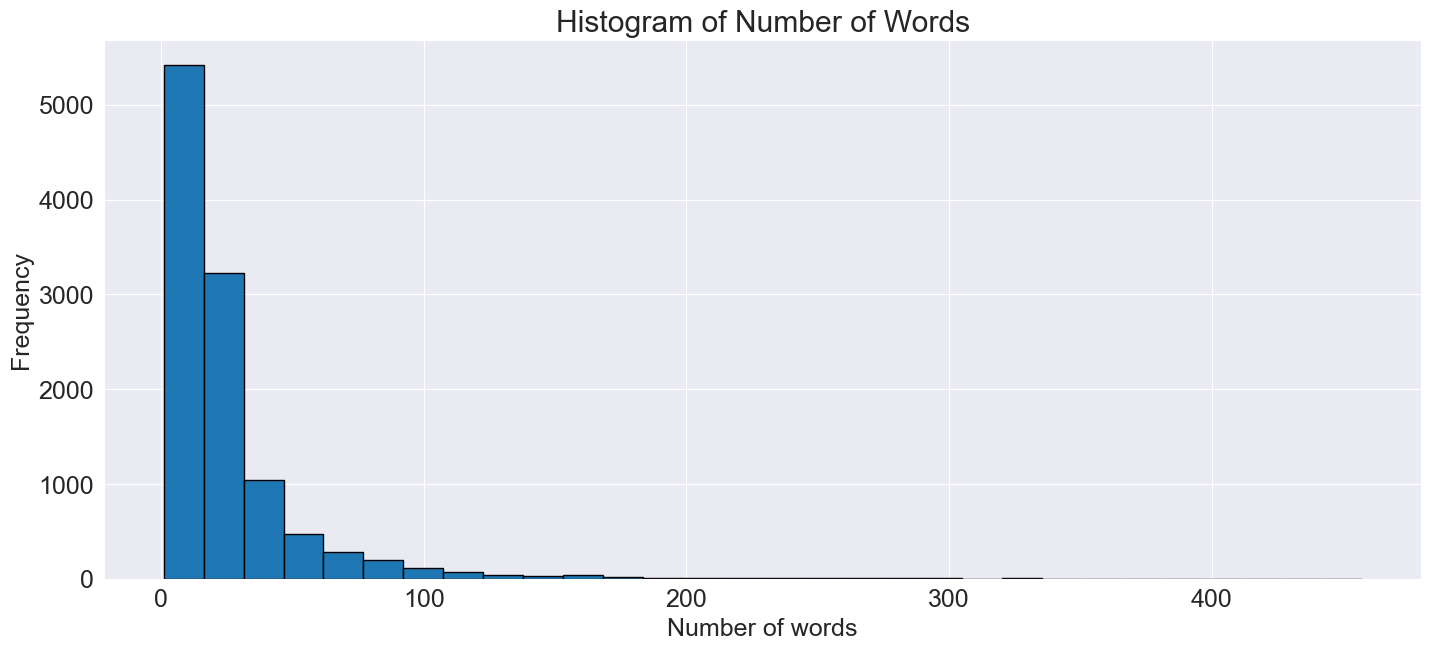

In [60]:
plt.hist(df['Word_count'], bins=30, edgecolor='black')
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.title("Histogram of Number of Words")
plt.show()

Este histograma muestra una distribución sesgada hacia la izquierda, lo que indica que la mayoría de los comentarios son cortos en términos de número de palabras. La mayor parte de los comentarios tienen menos de 50 palabras, con un pico pronunciado en el rango más bajo, lo que sugiere que muchos usuarios tienden a hacer comentarios concisos y directos.
A medida que aumenta el número de palabras, la frecuencia de los comentarios disminuye rápidamente. Hay pocos comentarios con más de 100 palabras, y casi ninguno supera las 200 palabras. Esto es consistente con el análisis de la longitud en caracteres, ya que tanto en caracteres como en palabras, los comentarios largos son una minoría.

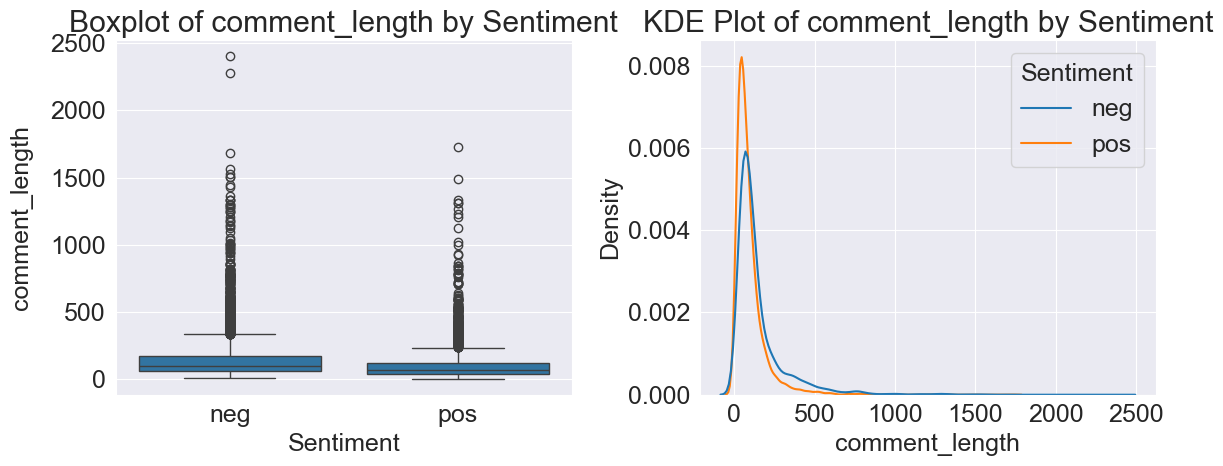

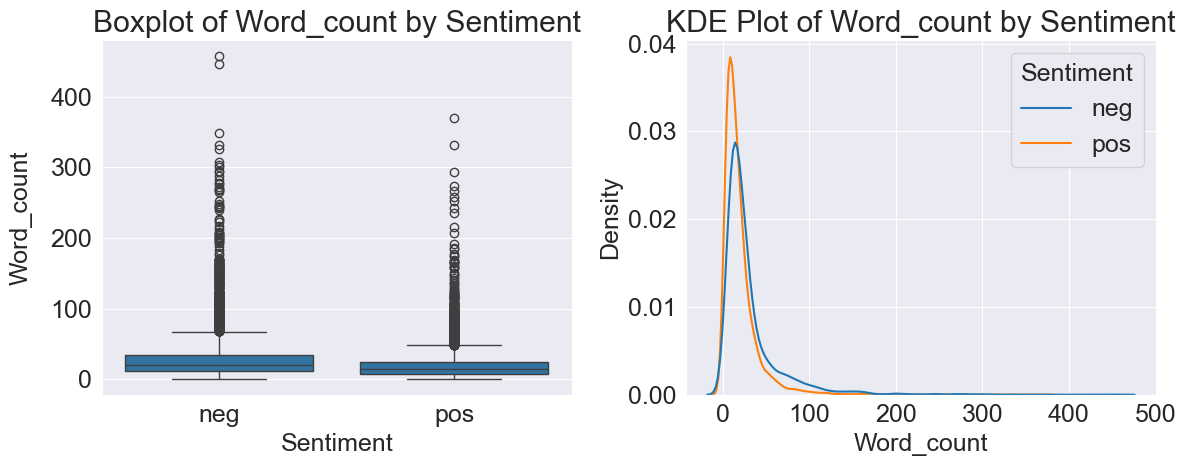

In [61]:
def visualize(col):
    plt.figure(figsize=(12, 5))
    
    # Boxplot for the specified column, comparing by sentiment label
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df[col], x=df['Sentiment'])
    plt.ylabel(col, labelpad=12.5)
    plt.title(f"Boxplot of {col} by Sentiment")
    
    # KDE plot for the specified column, comparing by sentiment label
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df, x=col, hue='Sentiment', common_norm=False)
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.title(f"KDE Plot of {col} by Sentiment")
    
    plt.tight_layout()
    plt.show()

# Define the columns to visualize
features = ['comment_length', 'Word_count']

# Apply the visualize function to each feature in the list
for feature in features:
    visualize(feature)

Tanto para comment_length como para Word_count, el boxplot muestra que la mayoría de los comentarios son cortos, con algunas observaciones muy largas (outliers) que se alejan del rango intercuartílico.
Las distribuciones para las etiquetas "pos" y "neg" son bastante similares, aunque los comentarios negativos parecen tener algunos valores máximos ligeramente más altos en ambas métricas.

Las gráficas KDE muestran la distribución de comment_length y Word_count para cada sentimiento. Ambas distribuciones están sesgadas hacia la izquierda, con la mayor densidad en valores bajos de longitud y conteo de palabras.
Las diferencias entre las curvas de densidad para "pos" y "neg" son mínimas, lo que sugiere que la longitud y el número de palabras no varían mucho entre comentarios positivos y negativos.

### Term Frecuency Analysis

Iniciamos limpiando los comentarios de nuestro dataset

In [62]:
def clean(review):
    
    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
    
    return review

df['Comment'] = df['Comment'].apply(clean)
df.head(10)

,Sentiment,Comment,comment_length,Word_count
0,neg,ab achanak khawaja saad rafique ko khiyaal aag...,116,22
1,neg,adha drama censor hi hojaye gaa khaas tor per ...,471,93
2,neg,bekaar fuzool end moti budhi laila jeet gayee ...,223,45
3,neg,choor kasuri choor jhootay ka moo kaala,40,7
4,neg,gali gali mein shor hai gaaanjaaaa shair chor hai,51,9
5,neg,hum kia aur hamari logic kia bhonkoon k muted ...,179,35
6,neg,imran khan altaf hussain chachoo haroon ab sad...,247,51
7,neg,lagta ha sab bhonkay hath xaray kar rahay hein...,154,28
8,neg,merey bahi tum saye kaha rahey hoo main tum ku...,771,154
9,neg,nawaz khanzaaney ka moun khul chukaa hai sab k...,58,11


Ahora convertimos en una lista cada palabra de cada comentario.

In [63]:
def corpus(text):
    text_list = text.split()
    return text_list

df['Comment_Lists'] = df['Comment'].apply(corpus)
df.head()

,Sentiment,Comment,comment_length,Word_count,Comment_Lists
0,neg,ab achanak khawaja saad rafique ko khiyaal aag...,116,22,"[ab, achanak, khawaja, saad, rafique, ko, khiy..."
1,neg,adha drama censor hi hojaye gaa khaas tor per ...,471,93,"[adha, drama, censor, hi, hojaye, gaa, khaas, ..."
2,neg,bekaar fuzool end moti budhi laila jeet gayee ...,223,45,"[bekaar, fuzool, end, moti, budhi, laila, jeet..."
3,neg,choor kasuri choor jhootay ka moo kaala,40,7,"[choor, kasuri, choor, jhootay, ka, moo, kaala]"
4,neg,gali gali mein shor hai gaaanjaaaa shair chor hai,51,9,"[gali, gali, mein, shor, hai, gaaanjaaaa, shai..."


Hallamos el Top 10 de las palabras mas comunes en el dataset.

In [65]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('hai', 399),
 ('ko', 340),
 ('ki', 325),
 ('k', 315),
 ('aur', 217),
 ('ka', 216),
 ('kay', 192),
 ('hain', 179),
 ('se', 168),
 ('hi', 154)]

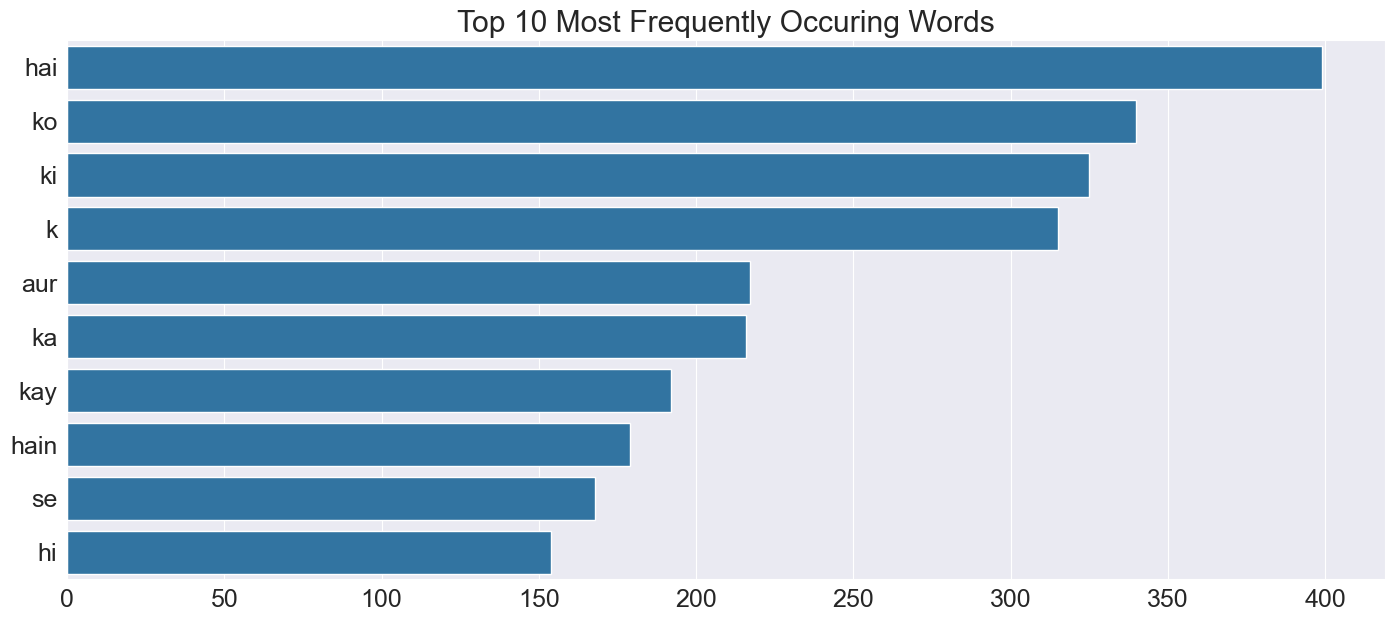

In [66]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

Observamos el top 10 de las palabras mas comunes en el dataset.
La mayoría de estas palabras son conectores y partículas gramaticales en urdu, que ayudan a formar la estructura de las oraciones pero no aportan mucho significado específico. Por ejemplo:

- "hai" (está/es)
- "ko" (a)
- "ki" (de)
- "aur" (y)
- "ka" (de)

In [69]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['Comment'])
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

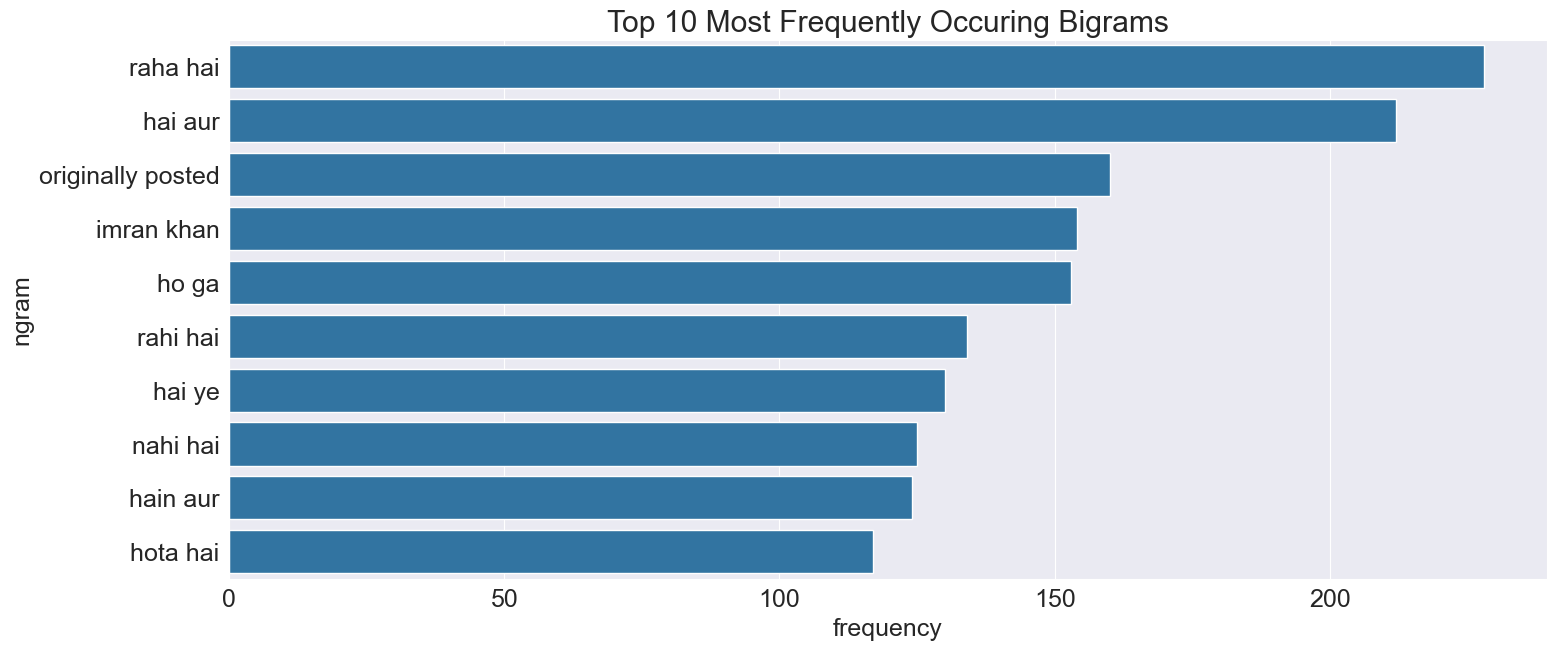

In [70]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

Observamos el Top 10 de Bigrams mas frecuentes en el dataset. En primer lugar tenemos 'raha hai', luego a 'hai aur'.

Los bigramas como "raha hai" (equivalente a "está sucediendo") y "hai aur" (equivalente a "es y") son construcciones gramaticales comunes en urdu, utilizadas para conectar ideas o describir acciones. Estos bigramas probablemente aparecen con frecuencia porque son parte de expresiones cotidianas.

Por otro lado, "Imran Khan" es un nombre propio que parece aparecer con frecuencia en los comentarios, posiblemente refiriéndose a una figura pública popular en el contexto de los datos. Esto sugiere que los comentarios pueden estar relacionados con temas políticos o sociales en los que Imran Khan es una figura relevante.

Bigramas como "ho ga" (será), "rahi hai" (está siendo), "nahi hai" (no es) y "hota hai" (sucede) son auxiliares y elementos estructurales en urdu, y contribuyen a la construcción de frases y expresiones en el idioma.

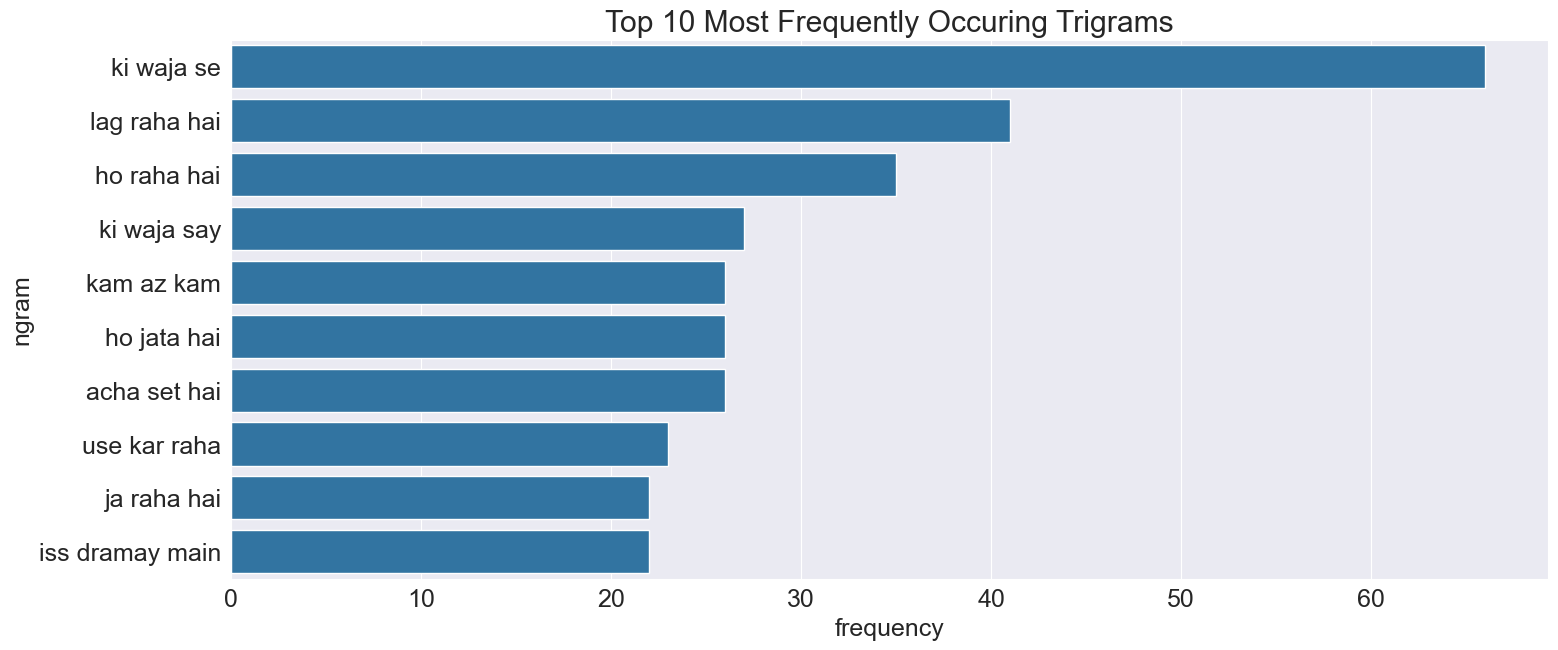

In [74]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['Comment'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

En este gráfico observamos el Top 10 de los Trigramas mas usados en el dataset. La mayoría de los trigramas representan expresiones comunes en urdu que se utilizan para conectar ideas o describir acciones. Por ejemplo:

- "ki waja se" (debido a) y "ki waja say" (debido a) sugieren que los comentarios explican razones o causas.
- "lag raha hai" (parece que) y "ho raha hai" (está sucediendo) son frases descriptivas que se usan para hablar de situaciones o percepciones.